# Problem Statement

The problem statement is to train the model on topics related to biology, cooking, robotics, travel, diy and crypto and use this model to predict the tags of topics related to Physics.

# Challenge

The challenge of this competition is that it violates the basic assumption of machine learning which is that the train and test data should come from the same distribution and here the training data and the test data are completely different from each other.

Since one title can belong to multiple categories at the same time this problem is a multilabel classification problem

# Solution Approach

On a high level the solution approach would look like this:

1. Data Ingestion
2. Data Cleaning
3. Data Preprocessing
4. Exploratory Data Analysis (EDA)
5. Feature Extraction
6. Model Training
7. Hyperparameter Tuning
8. Model Evaluation


# Import the necessary libraries

In [807]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn import preprocessing
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from scipy import sparse
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import joblib
import ast
import seaborn as sns
%matplotlib inline

# Data Ingestion

All the six data files biology, cooking, crypto, diy, robotics and travel were imported into a pandas dataframe and later all these six dataframes were appended into a single dataframe for analysis and model training

In [2]:
biology_data=pd.read_csv('./biology.csv/biology.csv')
cooking_data=pd.read_csv('./cooking.csv/cooking.csv')
crypto_data=pd.read_csv('./crypto.csv/crypto.csv')
diy_data=pd.read_csv('./diy.csv/diy.csv')
robotics_data=pd.read_csv('./robotics.csv/robotics.csv')
travel_data=pd.read_csv('./travel.csv/travel.csv')
test_data=pd.read_csv('./test.csv/test.csv')

In [3]:
test_data.head()

,id,title,content
0,1,What is spin as it relates to subatomic partic...,<p>I often hear about subatomic particles havi...
1,2,What is your simplest explanation of the strin...,<p>How would you explain string theory to non ...
2,3,"Lie theory, Representations and particle physics",<p>This is a question that has been posted at ...
3,7,Will Determinism be ever possible?,<p>What are the main problems that we need to ...
4,9,Hamilton's Principle,<p>Hamilton's principle states that a dynamic ...


In [4]:
biology_data.shape

(13196, 4)

In [5]:
cooking_data.shape

(15404, 4)

In [6]:
crypto_data.shape

(10432, 4)

In [7]:
diy_data.shape

(25918, 4)

In [8]:
robotics_data.shape

(2771, 4)

In [9]:
travel_data.shape

(19279, 4)

In [10]:
biology_data.shape[0] + cooking_data.shape[0] + crypto_data.shape[0] + diy_data.shape[0] + robotics_data.shape[0] + travel_data.shape[0]

87000

In [11]:
test_data.head()

,id,title,content
0,1,What is spin as it relates to subatomic partic...,<p>I often hear about subatomic particles havi...
1,2,What is your simplest explanation of the strin...,<p>How would you explain string theory to non ...
2,3,"Lie theory, Representations and particle physics",<p>This is a question that has been posted at ...
3,7,Will Determinism be ever possible?,<p>What are the main problems that we need to ...
4,9,Hamilton's Principle,<p>Hamilton's principle states that a dynamic ...


In [12]:
combined_data=pd.DataFrame()

In [13]:
combined_data=combined_data.append([biology_data,cooking_data,crypto_data,diy_data,robotics_data,travel_data])

In [14]:
combined_data.shape

(87000, 4)

In [15]:
combined_data.columns

Index(['id', 'title', 'content', 'tags'], dtype='object')

In [18]:
combined_data.head()

,id,title,content,tags
0,1,What is the criticality of the ribosome bindin...,"<p>In prokaryotic translation, how critical fo...",ribosome binding-sites translation synthetic-b...
1,2,How is RNAse contamination in RNA based experi...,<p>Does anyone have any suggestions to prevent...,rna biochemistry
2,3,Are lymphocyte sizes clustered in two groups?,<p>Tortora writes in <em>Principles of Anatomy...,immunology cell-biology hematology
3,4,How long does antibiotic-dosed LB maintain goo...,<p>Various people in our lab will prepare a li...,cell-culture
4,5,Is exon order always preserved in splicing?,<p>Are there any cases in which the splicing m...,splicing mrna spliceosome introns exons


In [19]:
combined_data.shape

(87000, 4)

# Data Cleaning

The text data consists of html tags and some leading and trailing spaces and hence we will write some helper function to clean our pandas dataframe

In [21]:
def remove_html_tags(text):
    """Remove html tags from a string"""
    import re
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)  

In [20]:
def remove_space(text):
    "Remove spaces from the text"
    s=text
    s=s.strip()
    return s

In [22]:
combined_data['title']=combined_data['title'].apply(lambda x: remove_html_tags(x))
combined_data['content']=combined_data['content'].apply(lambda x: remove_html_tags(x))

In [23]:
combined_data['title']=combined_data['title'].apply(lambda x: remove_space(x))
combined_data['content']=combined_data['content'].apply(lambda x: remove_space(x))


In [26]:
combined_data=combined_data.drop_duplicates(subset=['title'],)      #### Removing rows with duplicate titles


In [27]:
combined_data.shape

(86968, 4)

In [28]:
combined_data.head()

,id,title,content,tags
0,1,What is the criticality of the ribosome bindin...,"In prokaryotic translation, how critical for e...",ribosome binding-sites translation synthetic-b...
1,2,How is RNAse contamination in RNA based experi...,Does anyone have any suggestions to prevent RN...,rna biochemistry
2,3,Are lymphocyte sizes clustered in two groups?,Tortora writes in Principles of Anatomy and Ph...,immunology cell-biology hematology
3,4,How long does antibiotic-dosed LB maintain goo...,Various people in our lab will prepare a liter...,cell-culture
4,5,Is exon order always preserved in splicing?,Are there any cases in which the splicing mach...,splicing mrna spliceosome introns exons


In [29]:
combined_data.reset_index(drop=True,inplace=True)

# Data Preprocessing

Before doing further analysis and model training it is important to do some preprocessing. The following preprocessing will be done on the data

1. Tokenization
2. Stopwords Removal
3. Remove Punctuation
4. Lemmmatization
5. Lowercase all the words in the text
6. Combine the text of title and content column and train the model


In [30]:
def lemmatization(tokens):
    from nltk.stem.snowball import SnowballStemmer
    stemmer = SnowballStemmer("english")
    stemmed=[stemmer.stem(x) for x in tokens]
    return stemmed
    

In [31]:
def tokenize(text):
    from nltk.tokenize import sent_tokenize, word_tokenize 
    return word_tokenize(text)    

In [32]:
def remove_punctuation(tokens):
    words = [word for word in tokens if word.isalpha()]
    return words

In [33]:
def remove_stopwords(tokens):
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')
    extra_words = ['a', "a's", 'able', 'about', 'above', 'according', 'accordingly',
              'across', 'actually', 'after', 'afterwards', 'again', 'against',
              "ain't", 'all', 'allow', 'allows', 'almost', 'alone', 'along',
              'already', 'also', 'although', 'always', 'am', 'among', 'amongst',
              'an', 'and', 'another', 'any', 'anybody', 'anyhow', 'anyone',
              'anything', 'anyway', 'anyways', 'anywhere', 'apart', 'appear',
              'appreciate', 'appropriate', 'are', "aren't", 'around', 'as',
              'aside', 'ask', 'asking', 'associated', 'at', 'available', 'away',
              'awfully', 'b', 'be', 'became', 'because', 'become', 'becomes',
              'becoming', 'been', 'before', 'beforehand', 'behind', 'being',
              'believe', 'below', 'beside', 'besides', 'best', 'better',
              'between', 'beyond', 'both', 'brief', 'but', 'by', 'c', "c'mon",
              "c's", 'came', 'can', "can't", 'cannot', 'cant', 'cause',
              'causes', 'certain', 'certainly', 'changes', 'clearly', 'co',
              'com', 'come', 'comes', 'concerning', 'consequently', 'consider',
              'considering', 'contain', 'containing', 'contains',
              'corresponding', 'could', "couldn't", 'course', 'currently', 'd',
              'definitely', 'described', 'despite', 'did', "didn't",
              'different', 'do', 'does', "doesn't", 'doing', "don't", 'done',
              'down', 'downwards', 'during', 'e', 'each', 'edu', 'eg', 'eight',
              'either', 'else', 'elsewhere', 'enough', 'entirely', 'especially',
              'et', 'etc', 'even', 'ever', 'every', 'everybody', 'everyone',
              'everything', 'everywhere', 'ex', 'exactly', 'example', 'except',
              'f', 'far', 'few', 'fifth', 'first', 'five', 'followed',
              'following', 'follows', 'for', 'former', 'formerly', 'forth',
              'four', 'from', 'further', 'furthermore', 'g', 'get', 'gets',
              'getting', 'given', 'gives', 'go', 'goes', 'going', 'gone', 'got',
              'gotten', 'greetings', 'h', 'had', "hadn't", 'happens', 'hardly',
              'has', "hasn't", 'have', "haven't", 'having', 'he', "he's",
              'hello', 'help', 'hence', 'her', 'here', "here's", 'hereafter',
              'hereby', 'herein', 'hereupon', 'hers', 'herself', 'hi', 'him',
              'himself', 'his', 'hither', 'hopefully', 'how', 'howbeit',
              'however', 'i', "i'd", "i'll", "i'm", "i've", 'ie', 'if',
              'ignored', 'immediate', 'in', 'inasmuch', 'inc', 'indeed',
              'indicate', 'indicated', 'indicates', 'inner', 'insofar',
              'instead', 'into', 'inward', 'is', "isn't", 'it', "it'd", "it'll",
              "it's", 'its', 'itself', 'j', 'just', 'k', 'keep', 'keeps',
              'kept', 'know', 'knows', 'known', 'l', 'last', 'lately', 'later',
              'latter', 'latterly', 'least', 'less', 'lest', 'let', "let's",
              'like', 'liked', 'likely', 'little', 'look', 'looking', 'looks',
              'ltd', 'm', 'mainly', 'many', 'may', 'maybe', 'me', 'mean',
              'meanwhile', 'merely', 'might', 'more', 'moreover', 'most',
              'mostly', 'much', 'must', 'my', 'myself', 'n', 'name', 'namely',
              'nd', 'near', 'nearly', 'necessary', 'need', 'needs', 'neither',
              'never', 'nevertheless', 'new', 'next', 'nine', 'no', 'nobody',
              'non', 'none', 'noone', 'nor', 'normally', 'not', 'nothing',
              'novel', 'now', 'nowhere', 'o', 'obviously', 'of', 'off', 'often',
              'oh', 'ok', 'okay', 'old', 'on', 'once', 'one', 'ones', 'only',
              'onto', 'or', 'other', 'others', 'otherwise', 'ought', 'our',
              'ours', 'ourselves', 'out', 'outside', 'over', 'overall', 'own',
              'p', 'particular', 'particularly', 'per', 'perhaps', 'placed',
              'please', 'plus', 'possible', 'presumably', 'probably',
              'provides', 'q', 'que', 'quite', 'qv', 'r', 'rather', 'rd', 're',
              'really', 'reasonably', 'regarding', 'regardless', 'regards',
              'relatively', 'respectively', 'right', 's', 'said', 'same', 'saw',
              'say', 'saying', 'says', 'second', 'secondly', 'see', 'seeing',
              'seem', 'seemed', 'seeming', 'seems', 'seen', 'self', 'selves',
              'sensible', 'sent', 'serious', 'seriously', 'seven', 'several',
              'shall', 'she', 'should', "shouldn't", 'since', 'six', 'so',
              'some', 'somebody', 'somehow', 'someone', 'something', 'sometime',
              'sometimes', 'somewhat', 'somewhere', 'soon', 'sorry',
              'specified', 'specify', 'specifying', 'still', 'sub', 'such',
              'sup', 'sure', 't', "t's", 'take', 'taken', 'tell', 'tends', 'th',
              'than', 'thank', 'thanks', 'thanx', 'that', "that's", 'thats',
              'the', 'their', 'theirs', 'them', 'themselves', 'then', 'thence',
              'there', "there's", 'thereafter', 'thereby', 'therefore',
              'therein', 'theres', 'thereupon', 'these', 'they', "they'd",
              "they'll", "they're", "they've", 'think', 'third', 'this',
              'thorough', 'thoroughly', 'those', 'though', 'three', 'through',
              'throughout', 'thru', 'thus', 'to', 'together', 'too', 'took',
              'toward', 'towards', 'tried', 'tries', 'truly', 'try', 'trying',
              'twice', 'two', 'u', 'un', 'under', 'unfortunately', 'unless',
              'unlikely', 'until', 'unto', 'up', 'upon', 'us', 'use', 'used',
              'useful', 'uses', 'using', 'usually', 'uucp', 'v', 'value',
              'various', 'very', 'via', 'viz', 'vs', 'w', 'want', 'wants',
              'was', "wasn't", 'way', 'we', "we'd", "we'll", "we're", "we've",
              'welcome', 'well', 'went', 'were', "weren't", 'what', "what's",
              'whatever', 'when', 'whence', 'whenever', 'where', "where's",
              'whereafter', 'whereas', 'whereby', 'wherein', 'whereupon',
              'wherever', 'whether', 'which', 'while', 'whither', 'who',
              "who's", 'whoever', 'whole', 'whom', 'whose', 'why', 'will',
              'willing', 'wish', 'with', 'within', 'without', "won't", 'wonder',
              'would', 'would', "wouldn't", 'x', 'y', 'yes', 'yet', 'you',
              "you'd", "you'll", "you're", "you've", 'your', 'yours',
              'yourself', 'yourselves', 'z', 'zero', '','is','based','aa','aaa','aac','aad','aav','ab','aa','aa aa',
 'aa ab',
 'aa batteri',
 'aa lt',
 'aaa',
 'aabb',
 'aabb aabb',
 'aabbcc',
 'aac',
 'aad',
 'aasa',
 'aav',
 'ab']
    
    new_stop=stop_words + extra_words
    new_stop=list(set(new_stop))
    filtered_words=[word for word in tokens if word not in new_stop]
    return filtered_words

In [34]:
def lower_word(tokens):
    words = [word.lower() for word in tokens]
    return words


In [35]:
combined_data['title_words']=combined_data['title'].apply(lambda x: tokenize(x))

In [36]:
combined_data['content_words']=combined_data['content'].apply(lambda x: tokenize(x))

In [37]:
combined_data['title_words']=combined_data['title_words'].apply(lambda x: remove_punctuation(x))
combined_data['content_words']=combined_data['content_words'].apply(lambda x: remove_punctuation(x))


In [38]:
combined_data['title_words']=combined_data['title_words'].apply(lambda x: lower_word(x))
combined_data['content_words']=combined_data['content_words'].apply(lambda x: lower_word(x))

In [39]:
combined_data['title_words']=combined_data['title_words'].apply(lambda x: remove_stopwords(x))
combined_data['content_words']=combined_data['content_words'].apply(lambda x: remove_stopwords(x))

In [40]:
combined_data.reset_index(drop=True,inplace=True)

In [43]:
combined_data.head()

,id,title,content,tags,title_words,content_words
0,1,What is the criticality of the ribosome bindin...,"In prokaryotic translation, how critical for e...",ribosome binding-sites translation synthetic-b...,"[criticality, ribosome, binding, site, relativ...","[prokaryotic, translation, critical, efficient..."
1,2,How is RNAse contamination in RNA based experi...,Does anyone have any suggestions to prevent RN...,rna biochemistry,"[rnase, contamination, rna, experiments, preve...","[suggestions, prevent, rnase, contamination, w..."
2,3,Are lymphocyte sizes clustered in two groups?,Tortora writes in Principles of Anatomy and Ph...,immunology cell-biology hematology,"[lymphocyte, sizes, clustered, groups]","[tortora, writes, principles, anatomy, physiol..."
3,4,How long does antibiotic-dosed LB maintain goo...,Various people in our lab will prepare a liter...,cell-culture,"[long, lb, maintain, good, selection]","[people, lab, prepare, liter, lb, add, kanamyc..."
4,5,Is exon order always preserved in splicing?,Are there any cases in which the splicing mach...,splicing mrna spliceosome introns exons,"[exon, order, preserved, splicing]","[cases, splicing, machinery, constructs, mrna,..."


In [44]:
combined_data['text']=combined_data['title_words']+ combined_data['content_words']

In [54]:
combined_data.head()

,id,title,content,tags,title_words,content_words,text
0,1,What is the criticality of the ribosome bindin...,"In prokaryotic translation, how critical for e...",ribosome binding-sites translation synthetic-b...,"[criticality, ribosome, binding, site, relativ...","[prokaryotic, translation, critical, efficient...","[criticality, ribosome, binding, site, relativ..."
1,2,How is RNAse contamination in RNA based experi...,Does anyone have any suggestions to prevent RN...,rna biochemistry,"[rnase, contamination, rna, experiments, preve...","[suggestions, prevent, rnase, contamination, w...","[rnase, contamination, rna, experiments, preve..."
2,3,Are lymphocyte sizes clustered in two groups?,Tortora writes in Principles of Anatomy and Ph...,immunology cell-biology hematology,"[lymphocyte, sizes, clustered, groups]","[tortora, writes, principles, anatomy, physiol...","[lymphocyte, sizes, clustered, groups, tortora..."
3,4,How long does antibiotic-dosed LB maintain goo...,Various people in our lab will prepare a liter...,cell-culture,"[long, lb, maintain, good, selection]","[people, lab, prepare, liter, lb, add, kanamyc...","[long, lb, maintain, good, selection, people, ..."
4,5,Is exon order always preserved in splicing?,Are there any cases in which the splicing mach...,splicing mrna spliceosome introns exons,"[exon, order, preserved, splicing]","[cases, splicing, machinery, constructs, mrna,...","[exon, order, preserved, splicing, cases, spli..."


In [52]:
#combined_data.loc[0,'title_words']

In [55]:
combined_data['text']=combined_data['text'].apply(lambda x: lemmatization(x))

In [56]:
combined_data.text.head()

0    [critic, ribosom, bind, site, relat, start, co...
1    [rnase, contamin, rna, experi, prevent, sugges...
2    [lymphocyt, size, cluster, group, tortora, wri...
3    [long, lb, maintain, good, select, peopl, lab,...
4    [exon, order, preserv, splice, case, splice, m...
Name: text, dtype: object

In [57]:
combined_data['text']=combined_data['text'].apply(lambda x: ' '.join(x))

In [60]:
####################### Save Combined Data ############################################################
combined_data.to_csv('combined_data_preprocessed.csv',index=False)

# EDA (Exploratory Data Analysis)

Before training the model it is important to understand and explore the data. The following analysis will be done:

1. No. of datapoints corresponding to each category
2. Distribution of tags
3. Number of unique tags
4. Number of questions covered by taking x% of sample

## Datapoints corresponding to each category 

In [62]:
biology_data=biology_data.drop_duplicates(subset=['title'],) #### Removing rows with duplicate titles
travel_data=travel_data.drop_duplicates(subset=['title'],)      #### Removing rows with duplicate titles
cooking_data=cooking_data.drop_duplicates(subset=['title'],)      #### Removing rows with duplicate titles
robotics_data=robotics_data.drop_duplicates(subset=['title'],)      #### Removing rows with duplicate titles
diy_data=diy_data.drop_duplicates(subset=['title'],)      #### Removing rows with duplicate titles
crypto_data=crypto_data.drop_duplicates(subset=['title'],)      #### Removing rows with duplicate titles


In [79]:
datapoints=[]
datapoints.extend((biology_data.shape[0],travel_data.shape[0],cooking_data.shape[0],robotics_data.shape[0],diy_data.shape[0],
                  crypto_data.shape[0]))
topics=['biology','travel','cooking','robotics','diy','crypto']
topic_count=pd.DataFrame({'topics':topics,'datapoints':datapoints})
topic_count['percentage']=(topic_count['datapoints']/topic_count['datapoints'].sum())*100

In [129]:
topic_count.head()

,topics,datapoints,percentage
0,biology,13190,15.164754
1,travel,19276,22.161926
2,cooking,15403,17.709076
3,robotics,2770,3.184713
4,diy,25915,29.794891


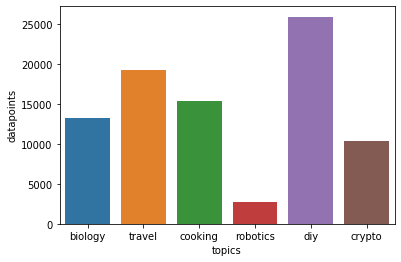

In [85]:
sns.barplot(x=topic_count['topics'],y=topic_count['datapoints'])

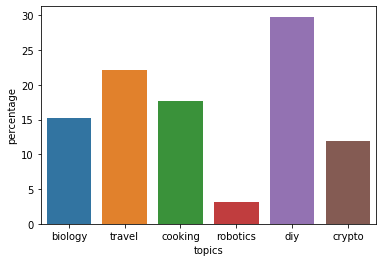

In [128]:
sns.barplot(x=topic_count['topics'],y=topic_count['percentage'])

The following observations can be drawn from the above plots:

1. diy has the highest number of datapoints (30%)
2. Robotics has the lowest number of datapoints (3.2 %)

This makes our problem statement harder because the language and vocabulary of robotics would have been closer to physics but the number of training datapoints are very less


### Distribution of tags

In [86]:
combined_data.head()

,id,title,content,tags,title_words,content_words,text
0,1,What is the criticality of the ribosome bindin...,"In prokaryotic translation, how critical for e...",ribosome binding-sites translation synthetic-b...,"[criticality, ribosome, binding, site, relativ...","[prokaryotic, translation, critical, efficient...",critic ribosom bind site relat start codon pro...
1,2,How is RNAse contamination in RNA based experi...,Does anyone have any suggestions to prevent RN...,rna biochemistry,"[rnase, contamination, rna, experiments, preve...","[suggestions, prevent, rnase, contamination, w...",rnase contamin rna experi prevent suggest prev...
2,3,Are lymphocyte sizes clustered in two groups?,Tortora writes in Principles of Anatomy and Ph...,immunology cell-biology hematology,"[lymphocyte, sizes, clustered, groups]","[tortora, writes, principles, anatomy, physiol...",lymphocyt size cluster group tortora write pri...
3,4,How long does antibiotic-dosed LB maintain goo...,Various people in our lab will prepare a liter...,cell-culture,"[long, lb, maintain, good, selection]","[people, lab, prepare, liter, lb, add, kanamyc...",long lb maintain good select peopl lab prepar ...
4,5,Is exon order always preserved in splicing?,Are there any cases in which the splicing mach...,splicing mrna spliceosome introns exons,"[exon, order, preserved, splicing]","[cases, splicing, machinery, constructs, mrna,...",exon order preserv splice case splice machiner...


In [89]:
tags_count = combined_data["tags"].apply(lambda x: len(x.split(" "))) # counting the number of tags for each datapoint


In [90]:
combined_data['Tags_Count'] = tags_count


In [91]:
combined_data.head()

,id,title,content,tags,title_words,content_words,text,Tags_Count
0,1,What is the criticality of the ribosome bindin...,"In prokaryotic translation, how critical for e...",ribosome binding-sites translation synthetic-b...,"[criticality, ribosome, binding, site, relativ...","[prokaryotic, translation, critical, efficient...",critic ribosom bind site relat start codon pro...,4
1,2,How is RNAse contamination in RNA based experi...,Does anyone have any suggestions to prevent RN...,rna biochemistry,"[rnase, contamination, rna, experiments, preve...","[suggestions, prevent, rnase, contamination, w...",rnase contamin rna experi prevent suggest prev...,2
2,3,Are lymphocyte sizes clustered in two groups?,Tortora writes in Principles of Anatomy and Ph...,immunology cell-biology hematology,"[lymphocyte, sizes, clustered, groups]","[tortora, writes, principles, anatomy, physiol...",lymphocyt size cluster group tortora write pri...,3
3,4,How long does antibiotic-dosed LB maintain goo...,Various people in our lab will prepare a liter...,cell-culture,"[long, lb, maintain, good, selection]","[people, lab, prepare, liter, lb, add, kanamyc...",long lb maintain good select peopl lab prepar ...,1
4,5,Is exon order always preserved in splicing?,Are there any cases in which the splicing mach...,splicing mrna spliceosome introns exons,"[exon, order, preserved, splicing]","[cases, splicing, machinery, constructs, mrna,...",exon order preserv splice case splice machiner...,5


In [92]:
print("Maximum number of tags per question = "+str(max(combined_data['Tags_Count'])))
print("Minimum number of tags per question = "+str(min(combined_data['Tags_Count'])))
print("Avg number of tags per question = "+str(sum(combined_data['Tags_Count'])/len(combined_data['Tags_Count'])))

Maximum number of tags per question = 5
Minimum number of tags per question = 1
Avg number of tags per question = 2.588066875172477


In [100]:
questions_per_tag=combined_data['Tags_Count'].value_counts()
questions_per_tag=pd.DataFrame(questions_per_tag)
questions_per_tag.reset_index(level=0,inplace=True)

In [106]:
questions_per_tag=questions_per_tag.rename(columns={'index':'tag_count','Tags_Count':'question_count'})

In [114]:
questions_per_tag['percentage']=(questions_per_tag['question_count']/questions_per_tag['question_count'].sum())*100

In [115]:
questions_per_tag.head()

,tag_count,question_count,percentage
0,2,26149,30.067381
1,3,23005,26.452258
2,1,18149,20.868595
3,4,12708,14.612271
4,5,6957,7.999494


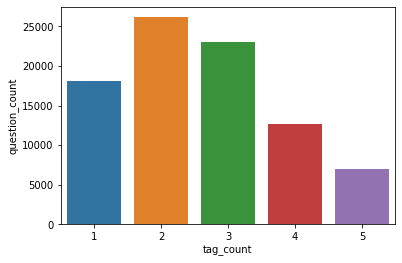

In [109]:
sns.barplot(x=questions_per_tag['tag_count'],y=questions_per_tag['question_count'])

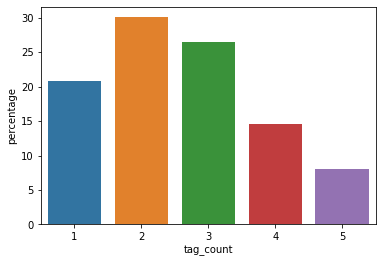

In [116]:
sns.barplot(x=questions_per_tag['tag_count'],y=questions_per_tag['percentage'])

From the above plot the following observations could be drawn

1. Only 8% of questions contains 5 tags
2. Majority of questions 30% contains 2 tags


## Tag Overlap 

In [809]:
combined_data['text_original']=combined_data['title_words'] + combined_data['content_words']

In [811]:
combined_data['tags_words']=combined_data['tags'].apply(lambda x: x.split(' '))

In [814]:
combined_data.drop(['text_original'],inplace=True,axis=1)

In [817]:
combined_data.head()

,id,title,content,tags,title_words,content_words,text,Tags_Count,tags_words
0,1,What is the criticality of the ribosome bindin...,"In prokaryotic translation, how critical for e...",ribosome binding-sites translation synthetic-b...,"[criticality, ribosome, binding, site, relativ...","[prokaryotic, translation, critical, efficient...",critic ribosom bind site relat start codon pro...,4,"[ribosome, binding-sites, translation, synthet..."
1,2,How is RNAse contamination in RNA based experi...,Does anyone have any suggestions to prevent RN...,rna biochemistry,"[rnase, contamination, rna, experiments, preve...","[suggestions, prevent, rnase, contamination, w...",rnase contamin rna experi prevent suggest prev...,2,"[rna, biochemistry]"
2,3,Are lymphocyte sizes clustered in two groups?,Tortora writes in Principles of Anatomy and Ph...,immunology cell-biology hematology,"[lymphocyte, sizes, clustered, groups]","[tortora, writes, principles, anatomy, physiol...",lymphocyt size cluster group tortora write pri...,3,"[immunology, cell-biology, hematology]"
3,4,How long does antibiotic-dosed LB maintain goo...,Various people in our lab will prepare a liter...,cell-culture,"[long, lb, maintain, good, selection]","[people, lab, prepare, liter, lb, add, kanamyc...",long lb maintain good select peopl lab prepar ...,1,[cell-culture]
4,5,Is exon order always preserved in splicing?,Are there any cases in which the splicing mach...,splicing mrna spliceosome introns exons,"[exon, order, preserved, splicing]","[cases, splicing, machinery, constructs, mrna,...",exon order preserv splice case splice machiner...,5,"[splicing, mrna, spliceosome, introns, exons]"


In [825]:
for i in range(0,len(combined_data)):
    print(i)
    tag_words=combined_data.loc[i,'tags_words']
    title_words=combined_data.loc[i,'title_words']
    common_title_words=set(tag_words)&set(title_words)
    combined_data.loc[i,'title_overlap']=len(common_title_words)

In [830]:
for i in range(0,len(combined_data)):
    print(i)
    tag_words=combined_data.loc[i,'tags_words']
    content_words=combined_data.loc[i,'content_words']
    common_content_words=set(tag_words)&set(content_words)
    combined_data.loc[i,'content_overlap']=len(common_content_words)

In [831]:
combined_data.head()

,id,title,content,tags,title_words,content_words,text,Tags_Count,tags_words,title_overlap,content_overlap
0,1,What is the criticality of the ribosome bindin...,"In prokaryotic translation, how critical for e...",ribosome binding-sites translation synthetic-b...,"[criticality, ribosome, binding, site, relativ...","[prokaryotic, translation, critical, efficient...",critic ribosom bind site relat start codon pro...,4,"[ribosome, binding-sites, translation, synthet...",2.0,2.0
1,2,How is RNAse contamination in RNA based experi...,Does anyone have any suggestions to prevent RN...,rna biochemistry,"[rnase, contamination, rna, experiments, preve...","[suggestions, prevent, rnase, contamination, w...",rnase contamin rna experi prevent suggest prev...,2,"[rna, biochemistry]",1.0,1.0
2,3,Are lymphocyte sizes clustered in two groups?,Tortora writes in Principles of Anatomy and Ph...,immunology cell-biology hematology,"[lymphocyte, sizes, clustered, groups]","[tortora, writes, principles, anatomy, physiol...",lymphocyt size cluster group tortora write pri...,3,"[immunology, cell-biology, hematology]",0.0,0.0
3,4,How long does antibiotic-dosed LB maintain goo...,Various people in our lab will prepare a liter...,cell-culture,"[long, lb, maintain, good, selection]","[people, lab, prepare, liter, lb, add, kanamyc...",long lb maintain good select peopl lab prepar ...,1,[cell-culture],0.0,0.0
4,5,Is exon order always preserved in splicing?,Are there any cases in which the splicing mach...,splicing mrna spliceosome introns exons,"[exon, order, preserved, splicing]","[cases, splicing, machinery, constructs, mrna,...",exon order preserv splice case splice machiner...,5,"[splicing, mrna, spliceosome, introns, exons]",1.0,3.0


In [832]:
combined_data['title_overlap_percent']=(combined_data['title_overlap']/combined_data['Tags_Count'])*100

In [835]:
combined_data['content_overlap_percent']=(combined_data['content_overlap']/combined_data['Tags_Count'])*100

In [838]:
combined_data.head()

,id,title,content,tags,title_words,content_words,text,Tags_Count,tags_words,title_overlap,content_overlap,title_overlap_percent,content_overlap_percent
0,1,What is the criticality of the ribosome bindin...,"In prokaryotic translation, how critical for e...",ribosome binding-sites translation synthetic-b...,"[criticality, ribosome, binding, site, relativ...","[prokaryotic, translation, critical, efficient...",critic ribosom bind site relat start codon pro...,4,"[ribosome, binding-sites, translation, synthet...",2.0,2.0,50.0,50.0
1,2,How is RNAse contamination in RNA based experi...,Does anyone have any suggestions to prevent RN...,rna biochemistry,"[rnase, contamination, rna, experiments, preve...","[suggestions, prevent, rnase, contamination, w...",rnase contamin rna experi prevent suggest prev...,2,"[rna, biochemistry]",1.0,1.0,50.0,50.0
2,3,Are lymphocyte sizes clustered in two groups?,Tortora writes in Principles of Anatomy and Ph...,immunology cell-biology hematology,"[lymphocyte, sizes, clustered, groups]","[tortora, writes, principles, anatomy, physiol...",lymphocyt size cluster group tortora write pri...,3,"[immunology, cell-biology, hematology]",0.0,0.0,0.0,0.0
3,4,How long does antibiotic-dosed LB maintain goo...,Various people in our lab will prepare a liter...,cell-culture,"[long, lb, maintain, good, selection]","[people, lab, prepare, liter, lb, add, kanamyc...",long lb maintain good select peopl lab prepar ...,1,[cell-culture],0.0,0.0,0.0,0.0
4,5,Is exon order always preserved in splicing?,Are there any cases in which the splicing mach...,splicing mrna spliceosome introns exons,"[exon, order, preserved, splicing]","[cases, splicing, machinery, constructs, mrna,...",exon order preserv splice case splice machiner...,5,"[splicing, mrna, spliceosome, introns, exons]",1.0,3.0,20.0,60.0


In [842]:
print("Average Title Overlap = {}".format(combined_data.title_overlap_percent.mean()))
print("Average Content Overlap = {}".format(combined_data.content_overlap_percent.mean()))


Average Title Overlap = 25.41471192469128
Average Content Overlap = 35.067611075340835


## Number of Unique Tags 

In [119]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(" "))
tagcount = vectorizer.fit_transform(combined_data['tags'])

In [121]:
print("Total number of datapoints = {}".format(tagcount.shape[0]))
print("Total number of unique tags = {}".format(tagcount.shape[1]))

Total number of datapoints = 86968
Total number of unique tags = 4268


In [130]:
print(vectorizer.get_feature_names()[0:10])

['120-240v', '240v', '2nd-preimage-resistance', '3d-model', '3d-printing', '3d-reconstruction', '3d-structure', '3des', '90-180-visa-rules', 'abe']


## Most frequent tags 

In [131]:
#top 10 highest occurring tags
col_sum = tagcount.sum(axis = 0).A1 
feat_count = dict(zip(vectorizer.get_feature_names(), col_sum))
feat_count_sorted = dict(sorted(feat_count.items(), key = lambda x: x[1], reverse = True))
count_data = {"Tags":list(feat_count_sorted.keys()), "Count": list(feat_count_sorted.values())}
count_df = pd.DataFrame(data = count_data)
count_df[:10]

,Tags,Count
0,electrical,4489
1,visas,3828
2,air-travel,2272
3,plumbing,2223
4,usa,2168
5,encryption,1777
6,wiring,1680
7,schengen,1559
8,uk,1521
9,human-biology,1448


In [134]:
count_df['Percentage']=(count_df['Count']/count_df['Count'].sum())*100

In [138]:
count_df.drop(['Oercentage'],axis=1,inplace=True)

In [140]:
count_df=count_df[:10]

In [141]:
count_df

,Tags,Count,Percentage
0,electrical,4489,1.994411
1,visas,3828,1.700736
2,air-travel,2272,1.009423
3,plumbing,2223,0.987653
4,usa,2168,0.963217
5,encryption,1777,0.789501
6,wiring,1680,0.746405
7,schengen,1559,0.692646
8,uk,1521,0.675763
9,human-biology,1448,0.643330


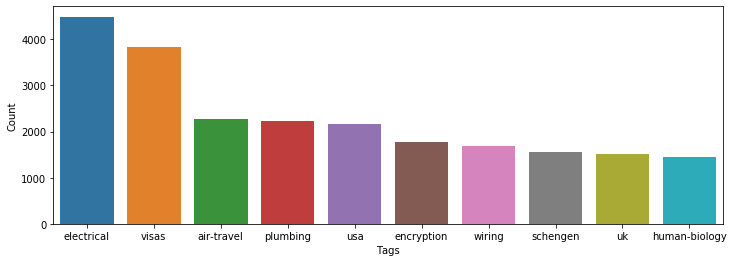

In [149]:
plt.figure(figsize = (12, 4))
sns.barplot(x=count_df['Tags'],y=count_df['Count'])

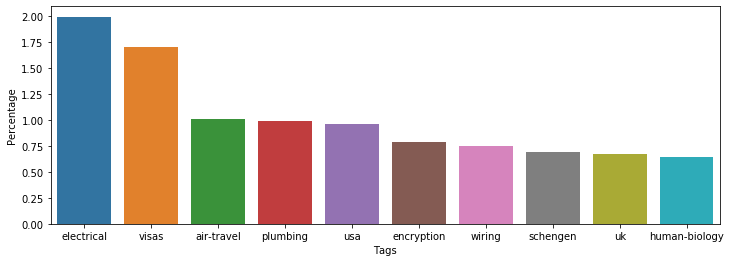

In [147]:
plt.figure(figsize = (12, 4))
sns.barplot(x=count_df['Tags'],y=count_df['Percentage'])

The above graph depicts the percentage of occurence of top 10 tags

1. The highest occuring tag electrical belongs to only 4489 (2 %) of the questions
2. Tags like i.e. visas, air-travel, usa, schengen and uk belong to travel which is not a science related topic

## Questions covered by Top n tags 

In [155]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(" "), binary = True)
labels = vectorizer.fit_transform(combined_data['tags'])

In [160]:
labels.shape

(86968, 4268)

In [159]:
col_sum = labels.sum(axis = 0).A1   
col_sum

array([17, 69, 32, ..., 11, 36,  1], dtype=int64)

In [161]:
sorted_tags = np.argsort(-col_sum)  
sorted_tags

array([1208, 4106,   71, ..., 3432,  603, 4267], dtype=int64)

In [162]:
def top_n_tags(n):
    multilabel_yn = labels[:,sorted_tags[:n]] 
    return multilabel_yn

def questionsCovered(n):
    multilabel_yn = top_n_tags(n)
    NonZeroQuestions = multilabel_yn.sum(axis = 1)  
    return np.count_nonzero(NonZeroQuestions), NonZeroQuestions

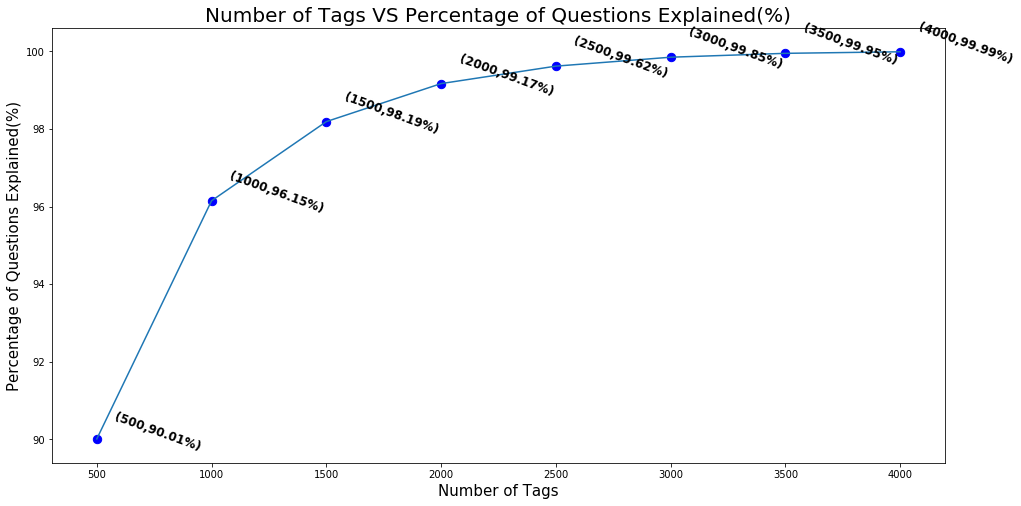

In [163]:
questionsExplained = []
numberOfTags = []
for i in range(500,4268,500):
    questionsExplained.append(round((questionsCovered(i)[0]/labels.shape[0])*100,2))
    numberOfTags.append(i)
    
plt.figure(figsize = (16, 8))
plt.plot(numberOfTags, questionsExplained)
plt.title("Number of Tags VS Percentage of Questions Explained(%)", fontsize=20)
plt.xlabel("Number of Tags", fontsize=15)
plt.ylabel("Percentage of Questions Explained(%)", fontsize=15)
plt.scatter(x = numberOfTags, y = questionsExplained, c = "blue", s = 70)
for x, y in zip(numberOfTags, questionsExplained):
    plt.annotate(s = '({},{}%)'.format(x, y), xy = (x, y), fontweight='bold', fontsize = 12, xytext=(x+70, y-0.3), rotation = -20)

The following import conclusions can be drawn:
1. 90 % of the questions are covered if we take top 500 labels
2. 96 % of the questions are covered if we take top 1000 labels

Based on the fact that we have limited computation power it would make sense to take top 500 labels and train our multilabel classification problem

In [170]:
sumOfRows = questionsCovered(500)[1]
RowIndicesZero = np.where(sumOfRows == 0)[0]  #this contains indices of all the questions for which the tags are removed
data_new = combined_data.drop(labels = RowIndicesZero, axis = 0)
data_new.reset_index(drop = True, inplace = True)
print("Size of new data = ",data_new.shape[0])

Size of new data =  78276


In [171]:
#removing tags from data
data_tags = top_n_tags(500)
df = pd.DataFrame(data_tags.toarray())
TagsDF_new = df.drop(labels = RowIndicesZero, axis = 0)
TagsDF_new.reset_index(drop = True, inplace = True)
print("Size of new data = ",TagsDF_new.shape[0])

Size of new data =  78276


As we can see that after taking the top 500 labels we are covering 78276 (90%) questions out of 86968 questions    

# Train and Validation Split

Now we will split our dataset into train and validation set and after that we will perform feature extraction using TF-IDF technique in order to feed our data to the machine learning model

In [174]:
allTags = sparse.csr_matrix(TagsDF_new.values)
x_train, x_test, y_train, y_test = train_test_split(data_new, allTags, test_size=0.20, random_state=42)


In [175]:
print("Train data shape ",x_train.shape)
print("Train label shape", y_train.shape)
print("Test data shape ",x_test.shape)
print("Test label shape", y_test.shape)

Train data shape  (62620, 8)
Train label shape (62620, 500)
Test data shape  (15656, 8)
Test label shape (15656, 500)


# Feature Extraction - Using TF-IDF

In order to train our multilabel classification model it is important to extract features from our text so that we can feed it into our classification algorithm.

We will use TF-IDF method to extract features from our dataset



In [176]:
vectorizer = TfidfVectorizer(max_features=10000, ngram_range = (1,3), tokenizer = lambda x: x.split(" "))
TrainData = vectorizer.fit_transform(x_train['text'])
TestData = vectorizer.transform(x_test['text'])


In [844]:
sparse.save_npz("FinalTrain.npz", TrainData)       ####### Saving Training and Test data in sparse format for later use  
sparse.save_npz("FinalTest.npz", TestData)
sparse.save_npz("FinalTrainLabels.npz", y_train)
sparse.save_npz("FinalTestLabels.npz", y_test)

In [845]:
FinalTrain = sparse.load_npz("FinalTrain.npz")      ####### Loading Training and Test Data for training
FinalTest = sparse.load_npz("FinalTest.npz")
FinalTrainLabels = sparse.load_npz("FinalTrainLabels.npz")
FinalTestLabels = sparse.load_npz("FinalTestLabels.npz")


print("Dimension of train data = ",TrainData.shape)
print("Dimension of test data = ",TestData.shape)
print("Dimension of train labels ",y_train.shape)
print("Dimension of Test labels ", y_test.shape)

Dimension of train data =  (62620, 10000)
Dimension of test data =  (15656, 10000)
Dimension of train labels  (62620, 500)
Dimension of Test labels  (15656, 500)


# Model Training - Logistic Regression

Now since we have splitted our dataset into train and validation set and also we have extracted tf-idf features from our dataset we are ready to train our model

Since it is a multilabel classification problem we will use Logistic Regression with one vs rest strategy in order to train our model

In [737]:
classifier= OneVsRestClassifier(LogisticRegression(C=0.9,penalty='l1',solver='saga'), n_jobs=-1)
classifier.fit(FinalTrain, FinalTrainLabels)
predictions = classifier.predict(FinalTest)

In [738]:
prediction_train=classifier.predict(FinalTrain)

In [740]:
print("Train Accuracy :",accuracy_score(FinalTrainLabels,prediction_train))
print("Train Macro f1 score :",f1_score(FinalTrainLabels, prediction_train, average = 'macro'))
print("Train Micro f1 scoore :",f1_score(FinalTrainLabels, prediction_train, average = 'micro'))
print("Train Classification Report :\n",classification_report(FinalTrainLabels, prediction_train))


Train Accuracy : 0.18206643244969659
Train Macro f1 score : 0.4342228386981097
Train Micro f1 scoore : 0.5075979006009609
Train Classification Report :
               precision    recall  f1-score   support

           0       0.76      0.67      0.72      3620
           1       0.77      0.72      0.74      3069
           2       0.70      0.44      0.54      1833
           3       0.71      0.53      0.60      1774
           4       0.76      0.38      0.51      1708
           5       0.53      0.24      0.33      1424
           6       0.53      0.29      0.37      1358
           7       0.88      0.74      0.81      1251
           8       0.82      0.63      0.71      1231
           9       0.62      0.22      0.32      1153
          10       0.67      0.42      0.52      1142
          11       0.67      0.36      0.47       986
          12       0.75      0.38      0.50       981
          13       0.84      0.56      0.67       943
          14       0.79      0.59   

In [741]:
print("Validation Accuracy :",accuracy_score(FinalTestLabels,predictions))
print("Validation Macro f1 score :",f1_score(FinalTestLabels, predictions, average = 'macro'))
print("Validation Micro f1 scoore :",f1_score(FinalTestLabels, predictions, average = 'micro'))
print("Validation Classification Report :\n",classification_report(FinalTestLabels, predictions))


Validation Accuracy : 0.1648569238630557
Validation Macro f1 score : 0.4053127055756746
Validation Micro f1 scoore : 0.47853434083329816
Validation Classification Report :
               precision    recall  f1-score   support

           0       0.72      0.64      0.68       869
           1       0.76      0.71      0.73       759
           2       0.66      0.45      0.53       439
           3       0.66      0.50      0.57       449
           4       0.72      0.35      0.47       460
           5       0.55      0.25      0.34       353
           6       0.46      0.30      0.36       322
           7       0.85      0.73      0.79       308
           8       0.78      0.62      0.69       290
           9       0.50      0.13      0.21       295
          10       0.63      0.38      0.48       302
          11       0.64      0.38      0.48       243
          12       0.67      0.31      0.42       230
          13       0.84      0.52      0.64       216
          14    

In [217]:
################## Save Model for later use #################################################
filename = 'best_model_l1_saga_f1_0.47.sav'
joblib.dump(classifier, filename)

['best_model_l1_saga_f1_0.47.sav']

# Model Training- Naive Bayes


In [729]:
classifier_1= OneVsRestClassifier(MultinomialNB(alpha=0.35), n_jobs=-1)
classifier_1.fit(FinalTrain, FinalTrainLabels)
predictions_1 = classifier_1.predict(FinalTest)

In [730]:
prediction_train_1=classifier_1.predict(FinalTrain)

In [731]:
print("Train Accuracy :",accuracy_score(FinalTrainLabels,prediction_train_1))
print("Train Macro f1 score :",f1_score(FinalTrainLabels, prediction_train_1, average = 'macro'))
print("Train Micro f1 scoore :",f1_score(FinalTrainLabels, prediction_train_1, average = 'micro'))
print("Train Classification Report :\n",classification_report(FinalTrainLabels, prediction_train_1))

Train Accuracy : 0.0773554774832322
Train Macro f1 score : 0.1534917560971775
Train Micro f1 scoore : 0.37088877572115025
Train Classification Report :
               precision    recall  f1-score   support

           0       0.66      0.89      0.76      3620
           1       0.58      0.98      0.73      3069
           2       0.44      0.67      0.53      1833
           3       0.57      0.83      0.67      1774
           4       0.32      0.64      0.42      1708
           5       0.26      0.78      0.39      1424
           6       0.35      0.78      0.48      1358
           7       0.39      0.96      0.55      1251
           8       0.33      0.74      0.46      1231
           9       0.45      0.34      0.39      1153
          10       0.45      0.66      0.53      1142
          11       0.50      0.59      0.54       986
          12       0.58      0.43      0.49       981
          13       0.67      0.65      0.66       943
          14       0.40      0.83   

In [732]:
print("Validation Accuracy :",accuracy_score(FinalTestLabels,predictions_1))
print("Validation Macro f1 score :",f1_score(FinalTestLabels, predictions_1, average = 'macro'))
print("Validation Micro f1 scoore :",f1_score(FinalTestLabels, predictions_1, average = 'micro'))
print("Validation Classification Report :\n",classification_report(FinalTestLabels, predictions_1))

Validation Accuracy : 0.05844404701073071
Validation Macro f1 score : 0.11182788112767271
Validation Micro f1 scoore : 0.3219067911679305
Validation Classification Report :
               precision    recall  f1-score   support

           0       0.65      0.88      0.75       869
           1       0.57      0.97      0.72       759
           2       0.42      0.62      0.50       439
           3       0.55      0.79      0.65       449
           4       0.32      0.57      0.41       460
           5       0.25      0.75      0.37       353
           6       0.32      0.71      0.44       322
           7       0.38      0.94      0.54       308
           8       0.30      0.69      0.42       290
           9       0.36      0.20      0.26       295
          10       0.46      0.62      0.53       302
          11       0.47      0.54      0.50       243
          12       0.51      0.33      0.40       230
          13       0.65      0.56      0.60       216
          14   

# Generating predictions on Test Set

In [218]:
test_data.head()

,id,title,content
0,1,What is spin as it relates to subatomic partic...,<p>I often hear about subatomic particles havi...
1,2,What is your simplest explanation of the strin...,<p>How would you explain string theory to non ...
2,3,"Lie theory, Representations and particle physics",<p>This is a question that has been posted at ...
3,7,Will Determinism be ever possible?,<p>What are the main problems that we need to ...
4,9,Hamilton's Principle,<p>Hamilton's principle states that a dynamic ...


In [219]:
test_data['title']=test_data['title'].apply(lambda x: remove_html_tags(x))
test_data['content']=test_data['content'].apply(lambda x: remove_html_tags(x))

In [220]:
test_data['title']=test_data['title'].apply(lambda x: remove_space(x))
test_data['content']=test_data['content'].apply(lambda x: remove_space(x))


In [221]:
test_data['title_words']=test_data['title'].apply(lambda x: tokenize(x))

test_data['content_words']=test_data['content'].apply(lambda x: tokenize(x))

In [222]:
test_data['title_words']=test_data['title_words'].apply(lambda x: remove_punctuation(x))
test_data['content_words']=test_data['content_words'].apply(lambda x: remove_punctuation(x))

In [223]:
test_data['title_words']=test_data['title_words'].apply(lambda x: lower_word(x))
test_data['content_words']=test_data['content_words'].apply(lambda x: lower_word(x))

In [224]:
test_data['title_words']=test_data['title_words'].apply(lambda x: remove_stopwords(x))
test_data['content_words']=test_data['content_words'].apply(lambda x: remove_stopwords(x))


In [225]:
test_data.reset_index(drop=True,inplace=True)
test_data['text']=test_data['title_words']+ test_data['content_words']


In [226]:
test_data['text']=test_data['text'].apply(lambda x: lemmatization(x))


In [227]:
test_data.head()

,id,title,content,title_words,content_words,text
0,1,What is spin as it relates to subatomic partic...,I often hear about subatomic particles having ...,"[spin, relates, subatomic, particles]","[hear, subatomic, particles, property, called,...","[spin, relat, subatom, particl, hear, subatom,..."
1,2,What is your simplest explanation of the strin...,How would you explain string theory to non phy...,"[simplest, explanation, string, theory]","[explain, string, theory, physicists, speciall...","[simplest, explan, string, theori, explain, st..."
2,3,"Lie theory, Representations and particle physics",This is a question that has been posted at man...,"[lie, theory, representations, particle, physics]","[question, posted, forums, thought, conceptual...","[lie, theori, represent, particl, physic, ques..."
3,7,Will Determinism be ever possible?,What are the main problems that we need to sol...,[determinism],"[main, problems, solve, prove, laplace, determ...","[determin, main, problem, solv, prove, laplac,..."
4,9,Hamilton's Principle,Hamilton's principle states that a dynamic sys...,"[hamilton, principle]","[hamilton, principle, states, dynamic, system,...","[hamilton, principl, hamilton, principl, state..."


In [228]:
test_data['text']=test_data['text'].apply(lambda x: ' '.join(x))
#test_data.to_csv('test_data_preprocessed.csv',index=False)

In [231]:
test_data.head()

,id,title,content,title_words,content_words,text
0,1,What is spin as it relates to subatomic partic...,I often hear about subatomic particles having ...,"[spin, relates, subatomic, particles]","[hear, subatomic, particles, property, called,...",spin relat subatom particl hear subatom partic...
1,2,What is your simplest explanation of the strin...,How would you explain string theory to non phy...,"[simplest, explanation, string, theory]","[explain, string, theory, physicists, speciall...",simplest explan string theori explain string t...
2,3,"Lie theory, Representations and particle physics",This is a question that has been posted at man...,"[lie, theory, representations, particle, physics]","[question, posted, forums, thought, conceptual...",lie theori represent particl physic question p...
3,7,Will Determinism be ever possible?,What are the main problems that we need to sol...,[determinism],"[main, problems, solve, prove, laplace, determ...",determin main problem solv prove laplac determ...
4,9,Hamilton's Principle,Hamilton's principle states that a dynamic sys...,"[hamilton, principle]","[hamilton, principle, states, dynamic, system,...",hamilton principl hamilton principl state dyna...


In [232]:
test_data.to_csv('test_data_preprocessed.csv',index=False)

In [155]:
#test_data['title_words']=test_data['title_words'].apply(lambda x: ast.literal_eval(x))
#test_data['content_words']=test_data['content_words'].apply(lambda x: ast.literal_eval(x))

In [156]:
#test_data['text']=test_data['title_words']*3 + test_data['content_words']

In [233]:
test_data.text.head()

0    spin relat subatom particl hear subatom partic...
1    simplest explan string theori explain string t...
2    lie theori represent particl physic question p...
3    determin main problem solv prove laplac determ...
4    hamilton principl hamilton principl state dyna...
Name: text, dtype: object

In [237]:
test_data.columns

Index(['id', 'title', 'content', 'title_words', 'content_words', 'text'], dtype='object')

In [236]:
len(vectorizer.get_feature_names())

10000

In [238]:
#vectorizer = TfidfVectorizer(max_features=50000, ngram_range = (1,3), tokenizer = lambda x: x.split(" "))
#TrainData = vectorizer.fit_transform(x_train['text'])
test_data_features = vectorizer.transform(test_data['text'])   ##### We will use the vectoriser which we fit on training data

In [239]:
test_data_features.shape

(81926, 10000)

In [240]:
predictions_test=classifier.predict(test_data_features)

In [241]:
predictions_test.shape

(81926, 500)

In [242]:
predictions_test_df=pd.DataFrame(predictions_test.toarray())

In [245]:
predictions_test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Get Column Names 

In [ ]:
vectorizer_label = CountVectorizer(tokenizer = lambda x: x.split(" "), binary = True)
new_labels = vectorizer_label.fit_transform(combined_data['tags'])

In [ ]:
len(vectorizer_label.get_feature_names())

In [ ]:
top_label_indices=sorted_tags[0:500]

In [ ]:
top_500=[vectorizer_label.get_feature_names()[i] for i in top_label_indices]


# Predictions Probability

In [847]:
predictions_probability=classifier.predict_proba(test_data_features)

In [848]:
predictions_probability=pd.DataFrame(predictions_probability)

In [849]:
predictions_probability.columns=top_500

In [850]:
predictions_probability.head()

,electrical,visas,air-travel,plumbing,usa,encryption,wiring,schengen,uk,human-biology,...,primer,ctr,marinade,repainting,home-automation,ingredient-selection,measurements,brazil,vapor-barrier,visas-on-arrival
0,0.010768,0.004151,0.006963,0.004589,0.006702,0.006504,0.005288,0.0011,0.002189,0.013248,...,0.000326,0.000322,0.000351,0.000372,0.000461,0.00079,0.000498,0.000422,0.000303,0.000448
1,0.007682,0.003269,0.006963,0.004449,0.006266,0.046888,0.003393,0.0011,0.002189,0.011830,...,0.000326,0.000322,0.000351,0.000372,0.000461,0.00079,0.000498,0.000422,0.000303,0.000448
2,0.008268,0.003822,0.007175,0.004381,0.006083,0.011001,0.003496,0.0011,0.002189,0.020729,...,0.000326,0.000322,0.000351,0.000372,0.000461,0.00079,0.000498,0.000422,0.000303,0.000448
3,0.015333,0.004151,0.006046,0.004895,0.006266,0.027837,0.004911,0.0011,0.001636,0.005583,...,0.000326,0.000322,0.000351,0.000372,0.000461,0.00079,0.000498,0.000422,0.000303,0.000448
4,0.010965,0.004151,0.009202,0.006641,0.016744,0.004921,0.003393,0.0011,0.002189,0.011736,...,0.000326,0.000322,0.000351,0.000372,0.000788,0.00079,0.000498,0.000422,0.000303,0.000448


In [851]:
for c in predictions_probability.columns.values.tolist():
    predictions_probability[c]=np.where(predictions_probability[c] >= 0.03,1,0)

# Prepare test data for Submission

In [852]:
cols_test = predictions_probability.columns


In [853]:
bt = predictions_probability.apply(lambda x: x > 0)


In [854]:
bt.head()

,electrical,visas,air-travel,plumbing,usa,encryption,wiring,schengen,uk,human-biology,...,primer,ctr,marinade,repainting,home-automation,ingredient-selection,measurements,brazil,vapor-barrier,visas-on-arrival
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [855]:
result=bt.apply(lambda x: list(cols_test[x.values]), axis=1)

In [856]:
result=pd.DataFrame(result)

In [857]:
result.columns=['tag']

In [858]:
result['tag']=result['tag'].apply(lambda x: ' '.join(x))

In [859]:
test_data.reset_index(drop=True,inplace=True)
result.reset_index(drop=True,inplace=True)
final_result=pd.concat([test_data,result],axis=1)

In [860]:
final_result.tag.unique()

array(['repair washing-machine localization', 'encryption evolution',
       'biochemistry diffie-hellman', ...,
       'evolution flavor fruit food-science measurements',
       'electrical molecular-biology bioinformatics initialization-vector',
       'electrical public-key'], dtype=object)

In [861]:
final_result.loc[final_result['tag']=="electrical"]

,id,title,content,title_words,content_words,text,tag
29,83,How is squeezed light produced?,Ordinary laser light has equal uncertainty in ...,"[squeezed, light, produced]","[ordinary, laser, light, equal, uncertainty, p...",squeez light produc ordinari laser light equal...,electrical
42,122,Is (rest) mass quantized?,I learned today in class that photons and ligh...,"[rest, mass, quantized]","[learned, today, class, photons, light, quanti...",rest mass quantiz learn today class photon lig...,electrical
97,335,Is electricity instantaneous?,My question is basically what exactly is elect...,"[electricity, instantaneous]","[question, basically, electricity, simply, tol...",electr instantan question basic electr simpli ...,electrical
159,566,Material resistency to lasers beam,"Keeping the average power constant, why some m...","[material, resistency, lasers, beam]","[keeping, average, power, constant, materials,...",materi resist laser beam keep averag power con...,electrical
201,763,Amount of 2 amperage,I have 2 equation describing the alternating a...,"[amount, amperage]","[equation, describing, alternating, amperage, ...",amount amperag equat describ altern amperag am...,electrical
...,...,...,...,...,...,...,...
81709,277656,Constructive interference and maximums of inte...,I am getting really confused about the experim...,"[constructive, interference, maximums, interfe...","[confused, experiment, michelson, morley, unde...",construct interfer maximum interfer confus exp...,electrical
81727,277688,Space Elevator Solved,Can hydrogen balloons be stacked all the way t...,"[space, elevator, solved]","[hydrogen, balloons, stacked, space, connected...",space elev solv hydrogen balloon stack space c...,electrical
81836,277939,Can a television detector van REALLY tell if y...,"In the UK, it was regularly advertised by the...","[television, detector, van, tv, switched]","[uk, regularly, advertised, bbc, post, office,...",televis detector van tv switch uk regular adve...,electrical
81840,277947,Electromagnetic wave equation with time varyin...,I am attempting to solve Maxwell's equations f...,"[electromagnetic, wave, equation, time, varyin...","[attempting, solve, maxwell, equations, electr...",electromagnet wave equat time vari phase veloc...,electrical


In [862]:
final_result.head()

,id,title,content,title_words,content_words,text,tag
0,1,What is spin as it relates to subatomic partic...,I often hear about subatomic particles having ...,"[spin, relates, subatomic, particles]","[hear, subatomic, particles, property, called,...",spin relat subatom particl hear subatom partic...,repair washing-machine localization
1,2,What is your simplest explanation of the strin...,How would you explain string theory to non phy...,"[simplest, explanation, string, theory]","[explain, string, theory, physicists, speciall...",simplest explan string theori explain string t...,encryption evolution
2,3,"Lie theory, Representations and particle physics",This is a question that has been posted at man...,"[lie, theory, representations, particle, physics]","[question, posted, forums, thought, conceptual...",lie theori represent particl physic question p...,biochemistry diffie-hellman
3,7,Will Determinism be ever possible?,What are the main problems that we need to sol...,[determinism],"[main, problems, solve, prove, laplace, determ...",determin main problem solv prove laplac determ...,
4,9,Hamilton's Principle,Hamilton's principle states that a dynamic sys...,"[hamilton, principle]","[hamilton, principle, states, dynamic, system,...",hamilton principl hamilton principl state dyna...,evolution


In [695]:
submission=final_result[['id','tag']]

In [696]:
submission.columns=['id','tags']

In [697]:
submission.head()

,id,tags
0,1,repair washing-machine
1,2,encryption sha-256
2,3,diffie-hellman attack
3,7,
4,9,


In [699]:
submission.to_csv('twelth_submission.csv',index=False)

# Conclusion

Based on the above analysis we conclude that the model performs satisfactory on Train and Validation set but the performance on test set is low.

1. Train Set: 0.50 (Micro F1 score)
2. Validation Set: 0.48 (Micro F1 score)
3. Test Set (Kaggle Submission): 0.011 (Micro F1 score)

The major reason for low F1 score on test set could be that the domain and vocabulary of the test set is very different from the one on which the model was trained on.

Although the score is less but by doing some more extensive feature engineering and hyperparameter tuning we can improve the performance of the model on test set

# Next Steps

Currently we have used TF-IDF for feature extraction and Logistic Regression for training a classifier model

In future we can improve the performance of the model by trying different techniques of feature extraction and model training

Feature Extraction Techniques
1. Increase the vocabulary of the TF-IDF feature extractor 
2. Extract POS tags from the text and use those POS tags as features to train our model
3. Perform LDA and use topic vectors as features to train the multilabel classification model
4. Train word2vec and doc2vec model on the data and use it to extract features from the data 
5. Extract features using Pretrained Models like Universal Sentence Encoder (USE) and BERT
6. Dimension Reduction techniques like PCA
7. During EDA we observed that content is matching with the tags more than title and hence we can give more weightage to content words as compared to title word and then train the model

Model Training techniques

1. Tree based models like Random Forest and XGBoost
2. Neural Network Models like CNN, RNN and DNN
3. Support Vector Machine (SVM)


Important Note: Currently in our multilabel classification problem we have made the assumption that all the labels are independent of each other. This assumption needs to be validated and accordingly the techniques needs to be modified  
